In [251]:
import pandas as pd
import os
import Levenshtein
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from itertools import product
import nltk
import numpy as np
import re
from collections import Counter
from functools import reduce
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

In [2]:
data_path = os.path.join(os.getcwd(),'Export and Import Data','data.csv')
data = pd.read_csv(data_path)

/Users/mcallistercs/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
fdi = pd.read_excel(r'10 Yr Investment Actvity_Ethiopia.xlsx')

# Fuzzy String Matching
Here we need to find the most similar `HS2_DSCRIPTION` for each `Investment Activity`. We'll use [token set ratios](https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/) to calculate string similarity.

The output will be an excel file with a column for the unique investment activities and another column for the proposed matching hs2 descriptions. These will need to be manually reviewed. Once reviewed, we can conduct either a Pearson's R or Spearman's Rho test to see if the datasets follow linear or monotonic functions, respectively. If those are promising, we can perform further tests.

In [4]:
fdi_activities = list(set(fdi['Investment Activity']))
hs2_descriptions = list(set(data['HS2_DSCRIPTION']))

In [5]:
ratios_dict = {k:{'match':None,'score':None} for k in fdi_activities}
alpha_re = re.compile('[^a-zA-Z]')
en_stop = set(nltk.corpus.stopwords.words('english'))
useless_words = ['parts','part','product','products','production','thereof','preparation','preparations',
                 'manufacture','manufacturing','expansion','processing','process','general','(grade)',
                 'one','excluding','grade','designated','specialized','similar','export','service']
for w in useless_words:
    en_stop.add(w)

for activity in fdi_activities:
    activity_tokens = [alpha_re.sub("",word.lower()) for word in activity.split(' ') if alpha_re.sub("",word.lower()) not in en_stop]
    activity_clean = " ".join(activity_tokens)
    ratios = []
    for hs2 in hs2_descriptions:
        hs2_tokens = [alpha_re.sub("",word.lower()) for word in hs2.split(' ') if alpha_re.sub("",word.lower()) not in en_stop]
        hs2_clean = " ".join(hs2_tokens)
        ratio = fuzz.token_set_ratio(activity_clean, hs2_clean)
        ratios.append(ratio)
    max_value = max(ratios)
    max_index = ratios.index(max_value)
    ratios_dict[activity]['match'] = hs2_descriptions[max_index]
    ratios_dict[activity]['score'] = max_value

In [6]:
matches = pd.DataFrame.from_dict(ratios_dict,orient='index').reset_index()
matches.columns = ['Investment Activity','HS2 Description', 'Match Score']
matches.sort_values(by=['HS2 Description','Match Score'],ascending=[False,False],inplace=True)

In [7]:
hs2_group = pd.DataFrame(matches.groupby(by='HS2 Description')['Investment Activity'].apply(lambda x: "|".join(x)))

In [8]:
hs2_group.reset_index(inplace=True)

In [152]:
#write to excel for manual review
writer = pd.ExcelWriter('hs2_fdi_mapping.xlsx')
hs2_group.to_excel(writer,'Sheet1')
writer.save()

# Joining the FDI and Ex-Im Data
Now that we have a reviewed spreadsheet confirming the mapping between HS2 Descriptions and Investment Activities, we can calculate the 5-year percent change in Net Weight of imports and exports for each HS2 code. Then we can map those to the number of investment activities for each HS2 Code.

### FDI data

In [177]:
def count_activities(x):
    """
    This gets the number of investment activities in the Investment Activity column.
    """
    if x is np.nan:
        return 0
    else:
        return str(x).count("|") + 1

In [178]:
fdi_df = pd.read_excel('HS2_fdi_mapping_MH.xlsx')
fdi_df['Investment Activity Count'] = fdi_df['Investment Activity'].apply(count_activities)
fdi_df.drop(labels=['Investment Activity','COMMENTS'],axis=1,inplace=True)

### Import Data

In [181]:
import_df = data[data['Direction'] == 'import']
import_df = pd.DataFrame(import_df.groupby(by=['HS2_DSCRIPTION','Year'])['Net Wt. (Kg)'].sum()).reset_index()
import_df = import_df.pivot(index='HS2_DSCRIPTION',columns='Year')['Net Wt. (Kg)']
assert(import_df.isnull().sum().sum()==0), "There are some null values, so we can't do the 5-year change for all"
import_df = import_df.pct_change(axis=1,periods=4).drop(labels=[2013,2014,2015,2016],axis=1)
import_df.reset_index(inplace=True)
import_df.columns = ['HS2 Description','Five-Year Import Percent Change']

In [182]:
# Nulls
import_df.isnull().sum()

HS2 Description                    0
Five-Year Import Percent Change    0
dtype: int64

### Export Data

In [183]:
export_df = data[data['Direction'] == 'export']
export_df = pd.DataFrame(export_df.groupby(by=['HS2_DSCRIPTION','Year'])['Net Wt. (Kg)'].sum()).reset_index()
export_df = export_df.pivot(index='HS2_DSCRIPTION',columns='Year')['Net Wt. (Kg)']
assert(export_df.isnull().sum().sum()==0), "There are some null values, so we can't do the 5-year change for all"

AssertionError: There are some null values, so we can't do the 5-year change for all

In [184]:
#since we don't have five years of export data for every HS2 code, we'll use the first and last values to calculate
#the percent change.
last = export_df.ffill(axis=1).iloc[:,-1]
first = export_df.bfill(axis=1).iloc[:, 0]
export_df = pd.concat([first,last],axis=1).pct_change(axis=1).drop(labels=2013,axis=1).reset_index()
export_df.columns = ['HS2 Description','Export Percent Change']

In [256]:
# Nulls
export_df.isnull().sum()

HS2 Description          0
Export Percent Change    0
dtype: int64

### Join the data together

In [185]:
dfs = [fdi_df, import_df, export_df]
df = reduce(lambda left,right: pd.merge(left,right,on='HS2 Description'), dfs)

# Exploratory Data Analysis
Here we'll check out the data distributions and correlations for our three data sets:
 - Investment Activity Count
 - Five-Year Import Percent Change
 - Export Percent Change

In [186]:
df.head()

,HS2 Description,Investment Activity Count,Five-Year Import Percent Change,Export Percent Change
0,"AIRCRAFT, SPACECRAFT, AND PARTS OF",0,0.999930,-0.998470
1,ALBUMINOIDAL SUBS; MODIFIED STARCHES; GLUES; E...,0,0.202589,-0.417683
2,ALUMINIUM AND ARTICLES THEREOF,16,1.072135,0.438832
3,ANIMAL/VEG FATS & OIL & THEIR CLEAVAGE PRODUCT...,0,0.467529,-0.049008
4,"ART OF APPAREL & CLOTHING ACCESS, KNITTED OR C...",2,0.172629,1.243263


In [187]:
df.isnull().sum()

HS2 Description                    0
Investment Activity Count          0
Five-Year Import Percent Change    0
Export Percent Change              0
dtype: int64

In [188]:
df.describe()

,Investment Activity Count,Five-Year Import Percent Change,Export Percent Change
count,94.000000,94.000000,9.400000e+01
mean,9.191489,3.007551,1.554976e+04
std,17.617365,12.000660,1.492006e+05
min,0.000000,-0.812819,-9.984703e-01
25%,0.000000,0.260891,-3.387754e-01
50%,3.000000,0.652225,1.782513e-01
75%,11.750000,1.183274,2.745656e+00
max,144.000000,98.656215,1.446674e+06


### Distributions

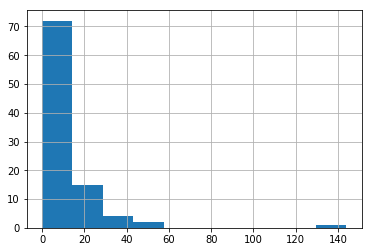

In [189]:
df['Investment Activity Count'].hist()

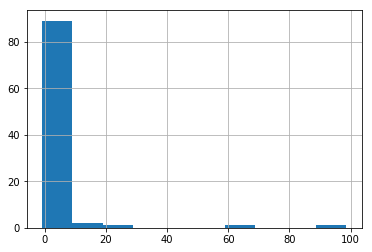

In [190]:
df['Five-Year Import Percent Change'].hist()

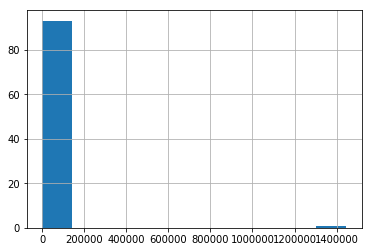

In [192]:
#there's a very large max value here, so let's see it's effect on the dist
df['Export Percent Change'].hist()

/Users/mcallistercs/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


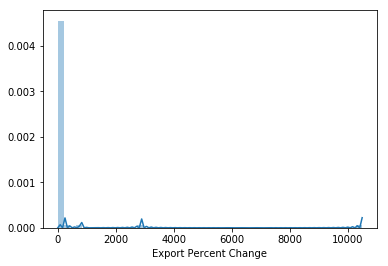

In [215]:
#let's drop outliers beyond +- 3 standard deviations for exports
x = df[np.abs(df['Export Percent Change']-df['Export Percent Change'].mean()) <= (3*df['Export Percent Change'].std())]['Export Percent Change']
sns.distplot(x)

Dropped 7 observations:
	ELECTRICAL MCHY EQUIP PARTS THEREOF; SOUND RECORDER ETC
	SUGARS AND SUGAR CONFECTIONERY
	SILK
	VEHICLES O/T RAILW/TRANW ROOL-STOCK, PTS & ACCESSORIES
	COPPER AND ARTICLES THEREOF
	FERTILISERS
	TOOL, IMPLEMENT, CUTLERY, SPOON & FORK, OF BASE MET ETC


/Users/mcallistercs/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


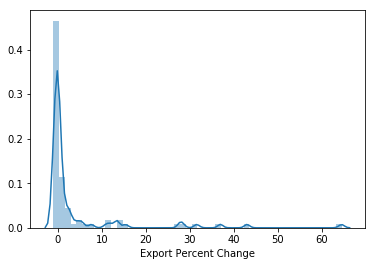

In [222]:
#That didn't do much, so let's drop values > the max import value
max_import_change = df['Five-Year Import Percent Change'].max()
x = df[df['Export Percent Change']<=max_import_change]['Export Percent Change']
print(f'Dropped {df.shape[0] - x.shape[0]} observations:')
dropped_hs2s = set(df['HS2 Description']) - set(df[df['Export Percent Change']<=max_import_change]['HS2 Description'])
for i in dropped_hs2s:
    print("\t"+i)
sns.distplot(x)

### Regression Plots

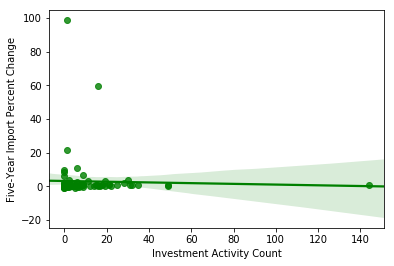

In [234]:
#imports
im_df = df
sns.regplot(x=im_df['Investment Activity Count'], 
            y=im_df['Five-Year Import Percent Change'],
            color="g")

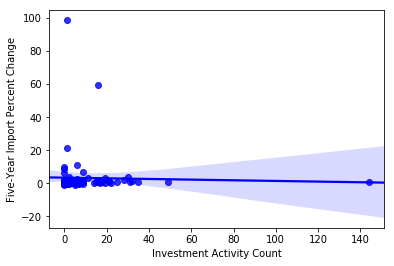

In [235]:
ex_df = df[~df['HS2 Description'].isin(dropped_hs2s)]
sns.regplot(x=ex_df['Investment Activity Count'], 
            y=ex_df['Five-Year Import Percent Change'],
            color="b")

# Testing
Due to the absence of normal distributions in the data, we'll use the [Spearman correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), which is a nonparametric measure of the [monotonicity](https://en.wikipedia.org/wiki/Monotonic_function) of the relationship between two datasets. Unlike the Pearson correlation coefficient, the Spearman correlation coefficient does make normality assumptions. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

In [257]:
#Exports
x=df['Investment Activity Count'].values 
y=df['Export Percent Change'].values
spearmanr(x,y)

SpearmanrResult(correlation=0.053115813751300624, pvalue=0.6111408045265478)

In [258]:
# Rerunning the tests after dropping export outliers
#Exports
x=ex_df['Investment Activity Count'].values 
y=ex_df['Export Percent Change'].values
spearmanr(x,y)

SpearmanrResult(correlation=0.00013483078841954396, pvalue=0.9990110799504959)

In [247]:
#Imports
x=im_df['Investment Activity Count'].values 
y=im_df['Five-Year Import Percent Change'].values
spearmanr(x,y)

SpearmanrResult(correlation=0.15481131827539996, pvalue=0.13625930473812314)

All of these tests give inconclusive results.

### Rerunning the test after dropping investment activity outliers

In [248]:
im_df2 = im_df[np.abs(im_df['Investment Activity Count']-im_df['Investment Activity Count'].mean()) <= (3*im_df['Investment Activity Count'].std())]
ex_df2 = ex_df[np.abs(ex_df['Investment Activity Count']-ex_df['Investment Activity Count'].mean()) <= (3*ex_df['Investment Activity Count'].std())]

In [249]:
#Exports
x=ex_df2['Investment Activity Count'].values 
y=ex_df2['Export Percent Change'].values
spearmanr(x,y)

SpearmanrResult(correlation=-0.02450374229497092, pvalue=0.8227987160003793)

In [250]:
#Imports
x=im_df2['Investment Activity Count'].values 
y=im_df2['Export Percent Change'].values
spearmanr(x,y)

SpearmanrResult(correlation=0.035354595120776176, pvalue=0.7365380653178577)

Still nothing conclusive.